#Быстрый анализ
##Убитые полицейскими в США

In [81]:
import pandas as pd

Данные взяты из https://www.kaggle.com/ahsen1330/us-police-shootings

Загружаем данные, осматриваем невооруженным взглядом. Оцениваем качество. Смотрим состав и наименование колонок.

In [82]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ii-8weeks/shootings.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4895 entries, 0 to 4894
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4895 non-null   int64  
 1   name                     4895 non-null   object 
 2   date                     4895 non-null   object 
 3   manner_of_death          4895 non-null   object 
 4   armed                    4895 non-null   object 
 5   age                      4895 non-null   float64
 6   gender                   4895 non-null   object 
 7   race                     4895 non-null   object 
 8   city                     4895 non-null   object 
 9   state                    4895 non-null   object 
 10  signs_of_mental_illness  4895 non-null   bool   
 11  threat_level             4895 non-null   object 
 12  flee                     4895 non-null   object 
 13  body_camera              4895 non-null   bool   
 14  arms_category           

Данные качественные, пропусков нет, тип данных задан верно (кроме "date"), большинство данных - категориальные.

Поля "id" и "name" нам не интересны, от них можем избавиться сразу.

In [84]:
df.drop(columns=['id', 'name'], inplace=True)

Поправим формат даты.

In [85]:
df['date'] = pd.to_datetime(df['date'])

Посмотрим распределение по времени: правда ли количество убийств в последнее время увеличилось?

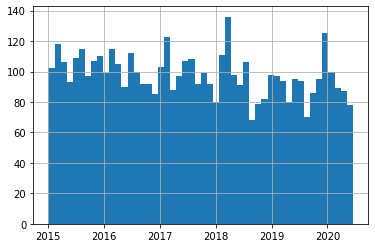

In [86]:
df['date'].hist(bins=50)

Не похоже: есть несколько всплесков, но в целом ничего критичного.

Давайте посмотрим на распределение по расе.

In [87]:
df['manner_of_death'].value_counts()

shot                4647
shot and Tasered     248
Name: manner_of_death, dtype: int64

Способов смерти два: "выстрел" и "выстрел и тазер". В этой колонке ничего интересного. 
Посмотрим, чем были вооружены убитые:

In [88]:
df['armed'].value_counts()

gun                    2755
knife                   708
unknown                 418
unarmed                 348
toy weapon              171
                       ... 
stapler                   1
machete and gun           1
car, knife and mace       1
BB gun and vehicle        1
pen                       1
Name: armed, Length: 89, dtype: int64

Здесь уже интереснее, из 4647 человек:
- 348 были не вооружены
- 2755 вооружены пистолетами
- 708 ножами
- 171 игрушечным оружием
- 1 был вооружен **степлером** 

Всего 89 вариантов.

Какие категориии оружия есть в этой таблице?

И к какой категории относится степлер?

In [89]:
df['arms_category'].value_counts()

Guns                     2764
Sharp objects             818
Unknown                   418
Unarmed                   348
Other unusual objects     192
Blunt instruments         122
Vehicles                  121
Multiple                   54
Piercing objects           29
Electrical devices         24
Explosives                  4
Hand tools                  1
Name: arms_category, dtype: int64

In [90]:
df[df['armed']=='stapler']

,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
703,2015-09-21,shot,stapler,34.0,M,Hispanic,Auburndale,FL,False,other,Foot,False,Other unusual objects


Этот 34-летний латинос убегал, отстреливаясь из степлера (который отнесен к категории "другие необычные предметы"). А еще у него не было признаков психических заболеваний. Ага.

Посмотрим распределение по возрасту:

In [91]:
print('Самый молодой:', df['age'].min())
print('Самый старый:', df['age'].max())

Самый молодой: 6.0
Самый старый: 91.0


In [92]:
df['age'].describe()

count    4895.000000
mean       36.549750
std        12.694348
min         6.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        91.000000
Name: age, dtype: float64

Жесть какая! Самому молодому было всего 6 лет, а старому 91.

Скорее всего это не норма. Построим гистограмму и ящик с усами:

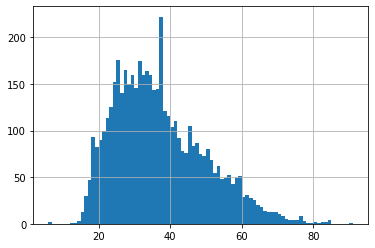

In [93]:
df['age'].hist(bins=85)

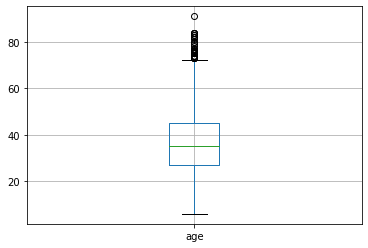

In [94]:
df.boxplot(column='age')

50% помещается в промежуток 27-45 лет.

Распределение по возрасту выглядит как распределение Пуассона: с 15 лет резко возрастает, резкий пик в 38 лет (согласно гистограмме) и постепенно снижается. После 70 - единичные случаи. Ящик с усами после 70 считает уже аномальными выбросами.

Посмотрим, что там по полу:

In [95]:
df['gender'].value_counts()

M    4673
F     222
Name: gender, dtype: int64

Здесь предсказуемо мужчин гораздо больше, чем женщин.

Посмотрим, много ли убитых были с поехавшей крышей:

In [96]:
df['signs_of_mental_illness'].value_counts()

False    3792
True     1103
Name: signs_of_mental_illness, dtype: int64

А в процентном соотношении?

In [97]:
df['signs_of_mental_illness'].value_counts() / len(df)

False    0.774668
True     0.225332
Name: signs_of_mental_illness, dtype: float64

Для меня очень неожиданно: 22% были психически нездоровы.

Выдвинем нулевую гипотезу: Процент нездоровых выше среди женщин.

Альтернативная гипотеза: процент среди мужчин и женщин примерно равен.

In [98]:
gender_illness = df.groupby('gender').agg({'signs_of_mental_illness':['count', 'mean']})
gender_illness

signs_of_mental_illness          
                         count      mean
gender                                  
F                          222  0.310811
M                         4673  0.221271

Действительно, 31% женщин были психически больны, а у мужчин 22%.

Посмотрим уровни угрозы:

In [99]:
df['threat_level'].value_counts()

attack          3160
other           1528
undetermined     207
Name: threat_level, dtype: int64

Не очень информативно. "атаковали", "не установлено" и "другое".

Посмотрим, сколько из атаковавших было мужчин и женщин здоровых и с поехавшей кукухой:

In [100]:
#gender_illness_attack = df[df['threat_level']=='attack'].pivot_table(index='gender', columns='signs_of_mental_illness', aggfunc='mean')
gender_illness_attack = df[df['threat_level']=='attack'].groupby('gender').agg({'signs_of_mental_illness':['count', 'mean']})
gender_illness_attack

signs_of_mental_illness          
                         count      mean
gender                                  
F                          131  0.297710
M                         3029  0.206999

Соотношение не сильно поменялось.

Посмотрим, много ли народа было убито при попытке к бегству:

In [101]:
df['flee'].value_counts()

Not fleeing    3073
Car             820
Foot            642
Other           360
Name: flee, dtype: int64

Нет! Оказывается 2/3 убитых вобще не убегали!

Можем посмотреть, сколько было записей с нательных камер полицейских:

In [102]:
df['body_camera'].value_counts()

False    4317
True      578
Name: body_camera, dtype: int64

Да, здесь все печально: записи есть всего у 578 случаев из 4895.

Ну и то, ради чего мы здесь собрались: распределение по рассам.

In [103]:
df['race'].value_counts()

White       2476
Black       1298
Hispanic     902
Asian         93
Native        78
Other         48
Name: race, dtype: int64

Интересно, белых убито в 2 раза больше, латиносов всего на 25% меньше в количественном выражении.

Посмотрим википедию на предмет процентного соотношения различных групп к общему населению США:

In [104]:
white = 0.637
black = 0.126
hispanic = 0.163
asian = 0.048
native = 0.009
other = 1 - white - black - hispanic - asian - native

In [105]:
t = pd.Series(data=[white, black, hispanic, asian, native, other])
t

0    0.637
1    0.126
2    0.163
3    0.048
4    0.009
5    0.017
dtype: float64

Соотношение убитых каждой группы к количеству всех убитых:

In [106]:
races = df['race'].value_counts() / len(df)
# races['total_population'] = t
races

White       0.505822
Black       0.265169
Hispanic    0.184270
Asian       0.018999
Native      0.015935
Other       0.009806
Name: race, dtype: float64

In [107]:
type(races)

pandas.core.series.Series

#Далее только наброски, доделать не успел :(

In [108]:
ra = pd.DataFrame(data=races).reset_index()
# ra = races.merge(t, how='outer')
ra

,index,race
0,White,0.505822
1,Black,0.265169
2,Hispanic,0.184270
3,Asian,0.018999
4,Native,0.015935
5,Other,0.009806


In [109]:
ra['total'] = t
ra

,index,race,total
0,White,0.505822,0.637
1,Black,0.265169,0.126
2,Hispanic,0.184270,0.163
3,Asian,0.018999,0.048
4,Native,0.015935,0.009
5,Other,0.009806,0.017


In [112]:
ra.columns = ['race', 'from_killed', 'from_total']
ra

,race,from_killed,from_total
0,White,0.505822,0.637
1,Black,0.265169,0.126
2,Hispanic,0.184270,0.163
3,Asian,0.018999,0.048
4,Native,0.015935,0.009
5,Other,0.009806,0.017


In [ ]:
ra['killed_from_total'] = 

In [111]:
df.pivot_table(index=['race', 'gender'], aggfunc=('count', 'mean'))

age             ... signs_of_mental_illness          
                count       mean  ...                   count      mean
race     gender                   ...                                  
Asian    F          4  38.000000  ...                       4  0.500000
         M         89  36.497032  ...                      89  0.247191
Black    F         47  34.808511  ...                      47  0.255319
         M       1251  32.465092  ...                    1251  0.137490
Hispanic F         26  31.542997  ...                      26  0.230769
         M        876  33.747389  ...                     876  0.172374
Native   F          5  31.200000  ...                       5  0.400000
         M         73  31.768739  ...                      73  0.164384
Other    F          4  31.250000  ...                       4  0.500000
         M         44  33.229953  ...                      44  0.204545
White    F        136  39.184691  ...                     136  0.330882
         M       2340  39.951613  ...                    2340  0.285470

[12 rows x 6 columns]